# **Part 3- Regression**

In [1]:
#importing needed libraries
import numpy as np
import pandas as pd 
import requests 
import io
import matplotlib.pyplot as plt
import sklearn.linear_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn import kernel_ridge
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

 **Pre**-**Processing**

In [2]:
#importing data
url="https://raw.githubusercontent.com/99Bella/COMP1832Irisdataset/main/Comp1801CourseworkData.csv"
download= requests.get(url).content
IncomeData = pd.read_csv(io.StringIO(download.decode('utf-8')))
lblEncoder_X = LabelEncoder()   
# apply LblEncoder object to our categorical variables to get numerical 
IncomeData['Education'] = lblEncoder_X.fit_transform(IncomeData['Education'])
IncomeData['WorkType'] = lblEncoder_X.fit_transform(IncomeData['WorkType'])
IncomeData['Sex'] = lblEncoder_X.fit_transform(IncomeData['Sex'])
IncomeData['Region'] = lblEncoder_X.fit_transform(IncomeData['Region'])
display(IncomeData)

#shuffle dataset 
rng = np.random.default_rng(0)
df = IncomeData.iloc[rng.permutation(len(IncomeData))].reset_index(drop=True)

#converting data to array
col =['Age', 'SiteSpending', 'SiteTime', 'RecommendImpression','WorkType', 'Education', 'Sex','Region']
#col =['Age', 'SiteSpending', 'SiteTime', 'RecommendImpression','WorkType', 'Education', 'Sex','Region']
X_raw = np.array(df[col]) #feature Matrix
y = np.array(df['Salary']) #target 

# Split the data- Train/Validation/Test with a ratio of 60:20:20
X_non_test_raw, X_test_raw, y_non_test, y_test = train_test_split(X_raw, y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_non_test_raw, y_non_test, test_size=0.25, shuffle=True, random_state=0)

,Age,SiteSpending,SiteTime,RecommendImpression,Education,WorkType,Sex,Region,Salary
0,32,314.06,30.14,0,1,0,1,2,60173.49
1,20,3758.36,149.36,4,2,0,0,7,42965.45
2,36,601.72,21.87,0,3,0,1,1,54924.41
3,21,44.89,182.80,9,3,0,0,5,26734.99
4,24,614.80,194.34,0,2,0,1,6,15325.23
...,...,...,...,...,...,...,...,...,...
995,56,177.67,272.87,5,2,1,0,4,22306.84
996,54,155.42,231.17,5,5,0,1,9,27704.97
997,22,2376.10,287.15,11,5,0,1,7,62542.89
998,49,4355.04,27.78,0,1,0,1,5,96745.84


**Polynomial Regression with Linear Regression Model**

The best degree of polynomials: 2


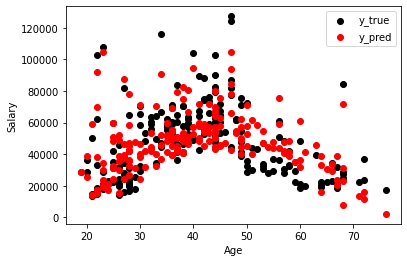

R2 score: 0.7272


In [7]:
#Tuning Hyperparameter 
max_degree = 10 #Define the max degree to test
# Initialise the MSE arrays, filling them with NaN's
mse_train_array = np.full([max_degree + 1], np.nan)
mse_valid_array = np.full([max_degree + 1], np.nan)
degrees = range(1, max_degree+1) # create list of degree values being iterated

for degree in degrees:
  
  # Initialise
  model = sklearn.linear_model.LinearRegression()
  poly = PolynomialFeatures(degree=degree)
  scaler = StandardScaler()
  # Train
  poly.fit(X_train_raw)
  X_train_poly = poly.transform(X_train_raw)
  scaler.fit(X_train_poly)
  X_train = scaler.transform(X_train_poly)  
  model.fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  mse_train = mean_squared_error(y_train, y_pred_train)

  # Validate
  X_valid_poly = poly.transform(X_valid_raw)
  X_valid = scaler.transform(X_valid_poly)  
  y_pred_valid = model.predict(X_valid)
  mse_valid = mean_squared_error(y_valid, y_pred_valid)

  # Store MSE for this degree value
  mse_train_array[degree] = mse_train
  mse_valid_array[degree] = mse_valid


best_degree = np.nanargmin(mse_valid_array) # Finds the smallest VALIDATION MSE in the array
print('The best degree of polynomials:', best_degree)

# Initialise the test instances
model = sklearn.linear_model.LinearRegression()
poly = PolynomialFeatures(degree=best_degree, interaction_only=False) 
scaler = StandardScaler()

# fit our preprocessors and model on the training data
poly.fit(X_train_raw)
X_train_poly = poly.transform(X_train_raw)
scaler.fit(X_train_poly)
X_train = scaler.transform(X_train_poly)  
model.fit(X_train, y_train)

# fit our preprocessors using the correct degree
X_test_poly = poly.transform(X_test_raw)
X_test = scaler.transform(X_test_poly)  
y_pred_test = model.predict(X_test)

#plot our outputs to see model
plt.scatter(X_test_raw[:,0], y_test,  color='black', label='y_true') # Observed y values
plt.scatter(X_test_raw[:,0], y_pred_test, color='red', label='y_pred') # predicted y values
plt.xlabel('Age')
plt.ylabel('Salary')
plt.legend()
plt.show()

#The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(y_test, y_pred_test)))

This is a decent score but going to try other regressions and compare for the highest.

**Ridge Regression**

The best alpha: 1.0


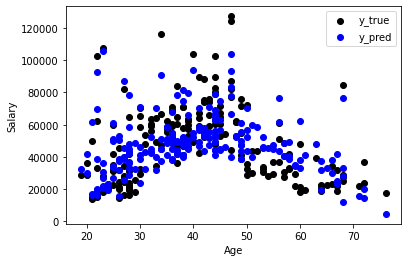

R2 score: 0.7159


In [6]:
###################################
# Initialise Model and preprocessors
###################################

degree = 2 #from polynomial regression
alpha_indices = np.arange(20) # Get a list of 1-20
alphas = 10.0 ** ( alpha_indices-10) # Define a list of alphas 
# Get the MSE arrays
mse_train_array = np.full([len(alphas)], np.nan) 
mse_valid_array = np.full([len(alphas)], np.nan)

poly = PolynomialFeatures(degree=degree)
scaler = StandardScaler()

#######################
# Training & validation 
#######################

# preprocessing
poly.fit(X_train_raw)
X_train_poly = poly.transform(X_train_raw)
scaler.fit(X_train_poly)
X_train = scaler.transform(X_train_poly)  
X_valid_poly = poly.transform(X_valid_raw)
X_valid = scaler.transform(X_valid_poly)  

# Loop to test alpha values
for alpha_index, alpha in zip(alpha_indices, alphas):
  # train
  model = Ridge(alpha=alpha) # fits our ridge model with a new regularisation weight each iteration
  model.fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  mse_train = mean_squared_error(y_train, y_pred_train)

  # Validation
  y_pred_valid = model.predict(X_valid)
  mse_valid = mean_squared_error(y_valid, y_pred_valid)

  # Store MSEs for this iteration
  mse_train_array[alpha_index] = mse_train
  mse_valid_array[alpha_index] = mse_valid
  

# Select our best performing alpha (lowest MSE)
best_alpha_index = np.nanargmin(mse_valid_array)
best_alpha = alphas[best_alpha_index]
#best_alpha = 100000.0
print('The best alpha:', best_alpha)

######
# Test
######
model = Ridge(alpha=best_alpha) # fits our ridge model with a new regularisation weight each iteration
model.fit(X_train, y_train)
# Preprocess test data
X_test_poly = poly.transform(X_test_raw)
X_test = scaler.transform(X_test_poly)  
# Predict test data
y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)


# Plot outputs
plt.scatter(X_test_raw[:,0], y_test,  color='black', label='y_true') # Observed y values
plt.scatter(X_test_raw[:,0], y_pred_test, color='blue', label='y_pred') # predicted y values
plt.xlabel('Age')
plt.ylabel('Salary')
plt.legend()
plt.show()

# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(y_test, y_pred_test)))

I experimentsed with different alphas and alpha indecies and the R2 score was not better that 0.72.

**Lasso regresssion**

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.364e+10, tolerance: 3.078e+07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.364e+10, tolerance: 3.078e+07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.362e+10, tolerance: 3.078e+07

The best alpha: 100.0


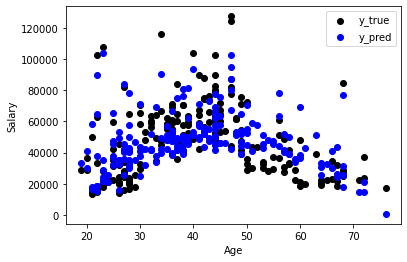

R2 score: 0.7108


In [8]:
# Initialise Model and preprocessors

degree = 2 # Choose any degree as Regularisation will try to eliminate any values that dont benifit model
alpha_indices = np.arange(20) # Get a list of 1-20
alphas = 10.0 ** (alpha_indices-10) # Define a list of alphas 
# Get the MSE arrays
mse_train_array = np.full([len(alphas)], np.nan) 
mse_valid_array = np.full([len(alphas)], np.nan)

poly = PolynomialFeatures(degree=degree)
scaler = StandardScaler()

# Training & validation 
# preprocessing
poly.fit(X_train_raw)
X_train_poly = poly.transform(X_train_raw)
scaler.fit(X_train_poly)
X_train = scaler.transform(X_train_poly)  
X_valid_poly = poly.transform(X_valid_raw)
X_valid = scaler.transform(X_valid_poly)  

#test alpha values
for alpha_index, alpha in zip(alpha_indices, alphas):
  # train
  model = Lasso(alpha=alpha) # fits Lasso model with a new regularisation weight each iteration
  model.fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  mse_train = mean_squared_error(y_train, y_pred_train)

  # Validation
  y_pred_valid = model.predict(X_valid)
  mse_valid = mean_squared_error(y_valid, y_pred_valid)

  # Store MSEs for this iteration
  mse_train_array[alpha_index] = mse_train
  mse_valid_array[alpha_index] = mse_valid

# Select our best performing alpha (lowest MSE)
best_alpha_index = np.argmin(mse_valid_array)
best_alpha = alphas[best_alpha_index]
print('The best alpha:', best_alpha)

# Test
#refit our model with the best alpha
model = Lasso(alpha=best_alpha, max_iter=1000) # fits Lasso model with a new regularisation weight each iteration
model.fit(X_train, y_train)

# Preprocess test data
X_test_poly = poly.transform(X_test_raw)
X_test = scaler.transform(X_test_poly)  

# Predict test data
y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)

# Plot outputs
plt.scatter(X_test_raw[:,0], y_test,  color='black', label='y_true') # Observed y values
plt.scatter(X_test_raw[:,0], y_pred_test, color='blue', label='y_pred') # predicted y values
plt.xlabel('Age')
plt.ylabel('Salary')
plt.legend()
plt.show()

# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(y_test, y_pred_test)))


Experimented with different aplha indicies and degree but did not get a R2 score higher that 0.7272

**Polynomial Regression with Kernel= 'Laplacian'**

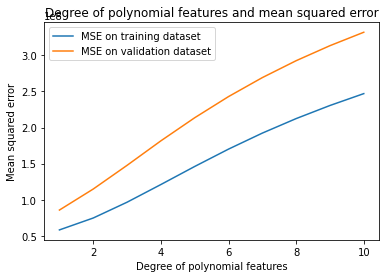

The best degree of polynomials: 1


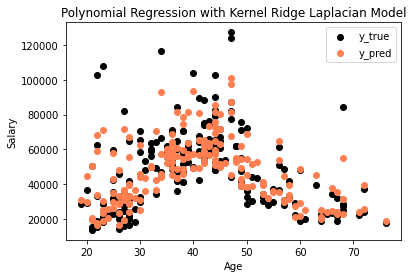

R2 score: 0.8573


In [10]:
#converting data to array
col =['Age', 'SiteSpending', 'SiteTime', 'RecommendImpression', 'Education', 'Sex','Region']
#col =['Age', 'SiteSpending', 'SiteTime', 'RecommendImpression','WorkType', 'Education', 'Sex','Region']
X_raw = np.array(df[col])
y = np.array(df['Salary']) #target 

# Split the data- Train/Validation/Train 
X_non_test_raw, X_test_raw, y_non_test, y_test = train_test_split(X_raw, y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_non_test_raw, y_non_test, test_size=0.25, shuffle=True, random_state=0)

max_degree = 10 #Define the max degree to test
# Initialise the MSE arrays, filling them with NaN's
mse_train_array = np.full([max_degree + 1], np.nan)
mse_valid_array = np.full([max_degree + 1], np.nan)
degrees = range(1, max_degree+1) # create list of degree values being iterated through

for degree in degrees:
  
  # Initialise
  model = kernel_ridge.KernelRidge(kernel='laplacian')
  poly = PolynomialFeatures(degree=degree)
  scaler = StandardScaler()
  # Train
  poly.fit(X_train_raw)
  X_train_poly = poly.transform(X_train_raw)
  scaler.fit(X_train_poly)
  X_train = scaler.transform(X_train_poly)  
  model.fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  mse_train = mean_squared_error(y_train, y_pred_train)

  # Validate
  X_valid_poly = poly.transform(X_valid_raw)
  X_valid = scaler.transform(X_valid_poly)  
  y_pred_valid = model.predict(X_valid)
  mse_valid = mean_squared_error(y_valid, y_pred_valid)

  # Store MSE for this degree value
  mse_train_array[degree] = mse_train
  mse_valid_array[degree] = mse_valid

plt.plot(degrees, mse_train_array[1:], label='MSE on training dataset')
plt.plot(degrees, mse_valid_array[1:], label='MSE on validation dataset')
plt.xlabel('Degree of polynomial features')
plt.ylabel('Mean squared error')
plt.title('Degree of polynomial features and mean squared error')
plt.legend()
plt.show()

best_degree = np.nanargmin(mse_valid_array) # Finds the smallest VALIDATION MSE in the array
print('The best degree of polynomials:', best_degree)

# Initialise the test instances
model = kernel_ridge.KernelRidge(kernel='laplacian')
poly = PolynomialFeatures(degree=best_degree, interaction_only=False) 
scaler = StandardScaler()

#fit our preprocessors and model on the training data again
poly.fit(X_train_raw)
X_train_poly = poly.transform(X_train_raw)
scaler.fit(X_train_poly)
X_train = scaler.transform(X_train_poly)  
model.fit(X_train, y_train)

# Now we have fit our preprocessors using the correct degree, we can process our test data and make a prdiction
X_test_poly = poly.transform(X_test_raw)
X_test = scaler.transform(X_test_poly)  
y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)

# Let's just plot our outputs to see how our model is looking
plt.scatter(X_test_raw[:,0], y_test,  color='black', label='y_true') # Observed y values
plt.scatter(X_test_raw[:,0], y_pred_test, color='coral', label='y_pred') # predicted y values
plt.xlabel('Age')
plt.ylabel('Salary')
plt.legend()
plt.title('Polynomial Regression with Kernel Ridge Laplacian Model')
plt.show()

#The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(y_test, y_pred_test)))



This is the best perfoming model based on R2 score. I did experimenataion by removing a feature to increase the score.

# **Part 4 - Classification**

In [11]:
import scipy
import seaborn as sns; sns.set()  # for plot styling
import sklearn.svm 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [12]:
IncomeData['Target'] = IncomeData['Salary'].apply(lambda x: 1 if x > 35000 else 0)
IncomeData.head()
#shuffle dataset 
rng = np.random.default_rng(0)
df = IncomeData.iloc[rng.permutation(len(IncomeData))].reset_index(drop=True)
df.Target.value_counts() # more salary above $35000
#converting data to array
col =['Age', 'SiteSpending', 'SiteTime', 'RecommendImpression','WorkType', 'Education', 'Sex','Region']
X = np.array(df[col])
y = np.array(df['Target']) #target 

n_train_points = 800
n_new_points = 200

# Split the data into training/new data
raw_X_train = X[:n_train_points]
raw_X_new = X[n_train_points:n_train_points+n_new_points]

# Split the targets into training/new data
y_train = y[:n_train_points]
y_new = y[n_train_points:n_train_points+n_new_points]

scaler = StandardScaler()
scaler.fit(raw_X_train) # calculate the mean and variance for each feature and store to attributes

X_train = scaler.transform(raw_X_train) # standardize X_train
X_new=scaler.transform(raw_X_new)



**Logistic Regression**

Accuracy: 0.6350
Confusion matrix:  [[0.155 0.23 ]
 [0.135 0.48 ]]
              precision    recall  f1-score   support

           0       0.53      0.40      0.46        77
           1       0.68      0.78      0.72       123

    accuracy                           0.64       200
   macro avg       0.61      0.59      0.59       200
weighted avg       0.62      0.64      0.62       200



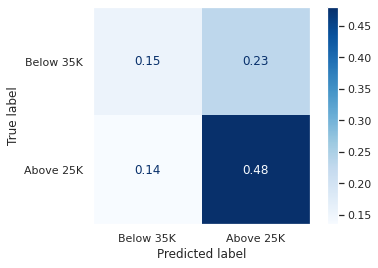

In [14]:
# Create logistic regression object

obj = sklearn.linear_model.LogisticRegression(penalty='l2', C=0.01, solver='liblinear',random_state=40)
# Tuning hyperparamters: obj = sklearn.linear_model.LogisticRegression(penalty='l1', C=0.01, solver='liblinear',random_state=40)

# Train the model using the training sets
obj.fit(X_train, y_train)

# Make predictions using the testing set
y_new_pred = obj.predict(X_new)

# The accuracy score: 1 for perfect prediction
print('Accuracy: {:.4f}'.format(sklearn.metrics.accuracy_score(y_new, y_new_pred)))
# Confusion matrix
confusion_mat = sklearn.metrics.confusion_matrix(y_new, y_new_pred, normalize='all')
print('Confusion matrix: ', confusion_mat)
# Visualize the confusion matrix
sklearn.metrics.ConfusionMatrixDisplay(confusion_mat, display_labels=['Below 35K', 'Above 25K']).plot(cmap=plt.cm.Blues)
plt.grid(False)
# The classification report
print(sklearn.metrics.classification_report(y_new, y_new_pred))



**SVM**

Accuracy: 0.6350
Confusion matrix:  [[0.155 0.23 ]
 [0.135 0.48 ]]
              precision    recall  f1-score   support

           0       0.53      0.40      0.46        77
           1       0.68      0.78      0.72       123

    accuracy                           0.64       200
   macro avg       0.61      0.59      0.59       200
weighted avg       0.62      0.64      0.62       200



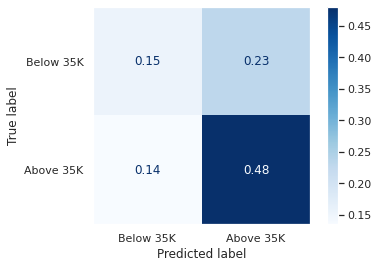

In [16]:
#converting data to array
col =['Age', 'SiteSpending', 'SiteTime', 'RecommendImpression','WorkType', 'Education', 'Sex','Region']
X = np.array(df[col])
y = np.array(df['Target']) #target 

# Create support vector classifier object
obj = sklearn.svm.SVC(C=1,kernel='rbf',random_state=40)

# Train the model using the training sets
obj.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = obj.predict(X_new)

# The accuracy score: 1 for perfect prediction
print('Accuracy: {:.4f}'.format(sklearn.metrics.accuracy_score(y_new, y_new_pred)))
# Confusion matrix
confusion_mat = sklearn.metrics.confusion_matrix(y_new, y_new_pred, normalize='all')
print('Confusion matrix: ', confusion_mat)
# Visualize the confusion matrix
sklearn.metrics.ConfusionMatrixDisplay(confusion_mat, display_labels=['Below 35K', 'Above 35K']).plot(cmap=plt.cm.Blues)
plt.grid(False)
# The classification report
print(sklearn.metrics.classification_report(y_new, y_new_pred))

**Decision Tree**

Accuracy: 0.9400
Confusion matrix:  [[0.355 0.03 ]
 [0.03  0.585]]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        77
           1       0.95      0.95      0.95       123

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94      0.94       200



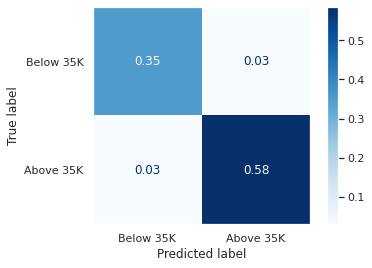

In [32]:
# Create Decison Tree object
obj = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=6,random_state=40)
#Tuning Hyperparemeters, obj = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=9,random_state=40)

# Train the model using the training sets
obj.fit(X_train, y_train)

# Make predictions using the testing set
y_new_pred = obj.predict(X_new)

# The accuracy score: 1 for perfect prediction
print('Accuracy: {:.4f}'.format(sklearn.metrics.accuracy_score(y_new, y_new_pred)))
# Confusion matrix
confusion_mat = sklearn.metrics.confusion_matrix(y_new, y_new_pred, normalize='all')
print('Confusion matrix: ', confusion_mat)
# Visualize the confusion matrix
sklearn.metrics.ConfusionMatrixDisplay(confusion_mat, display_labels=['Below 35K', 'Above 35K']).plot(cmap=plt.cm.Blues)
plt.grid(False)
# The classification report, which contains accuracy, precision, recall, F1 score
print(sklearn.metrics.classification_report(y_new, y_new_pred))

After doing 3 classifications, Decision Tree is best based on Accuracy score

# **Part 5- Neural Networks**

In [33]:
# Below are a wide selection of tensorflow libraries we will need to construct our Neural networks.
from tensorflow.keras.activations import sigmoid, linear, relu # Activation functions we will use
from tensorflow.keras.models import Model, Sequential # Different mays of constructing models, we will primarily be covering the 'functional api' which uses `Model`
from tensorflow.keras.optimizers import SGD # We will be using the SGD optimiser today, though there are other options you may want to explore (such as Adam)
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy  # We will be using TFs MSE loss function for regression and BinaryCross Entropy for classification.
from tensorflow.keras.layers import Input, Dense, Dropout # The layers we will be using to construct our network.
from tensorflow.keras.regularizers import L1, L2 # Regularisation being used in model layers
from tensorflow.keras.metrics import BinaryAccuracy # Accuracy Metric for classification
from tensorflow.keras.callbacks import EarlyStopping # Allows Early Stopping regularisation method.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report, balanced_accuracy_score # Various classification metrics we may find useful


In [34]:
IncomeData.head()
# prepare NumPy ndarrays
col =['Age', 'SiteSpending', 'SiteTime', 'RecommendImpression','WorkType', 'Education', 'Sex','Region']
X_raw = np.array(df[col])
Y = np.array(df['Target']) #target 

# Split the data into training/test data
X_nontest_raw, X_test_raw, Y_nontest, Y_test = train_test_split(X_raw, Y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, Y_train, Y_valid = train_test_split(X_nontest_raw, Y_nontest, test_size=0.25, shuffle=True, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)
X_test = scaler.transform(X_test_raw)

print('The shape of `X_train`:', X_train.shape)
print('The shape of `X_valid`:', X_valid.shape)
print('The shape of `X_test`:', X_test.shape)


The shape of `X_train`: (600, 8)
The shape of `X_valid`: (200, 8)
The shape of `X_test`: (200, 8)


**NN** with one layer

In [16]:
# Define the regularizer.
alpha = 0.01
kernel_regularizer = L1(l1=alpha)
#kernel_regularizer = L2(l2=alpha)

# Define the `Dense` layer.
dense_layer_1 = Dense(units=10, activation=relu, kernel_regularizer=kernel_regularizer)
output_layer = Dense(units=1, activation=sigmoid, kernel_regularizer=kernel_regularizer)

# Define the "virtual" input
input = Input(shape=X_train.shape[1:])

# Define the "virtual" output
output = dense_layer_1(input)
output = output_layer(output)

# Define the neural network model.
model = Model(inputs=[input], outputs=[output], name='logistic_regression_balanced')

# Output the summary of the model.
model.summary()

Model: "logistic_regression_balanced"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_14 (Dense)            (None, 10)                90        
                                                                 
 dense_15 (Dense)            (None, 1)                 11        
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


7/7 [==============================] - 0s 2ms/step - loss: 1.2721 - binary_accuracy: 0.3900
The cross entropy loss on the test data: 1.2720791101455688
The accuracy on the test data: 0.38999998569488525
Epoch 1/100
6/6 [==============================] - 0s 15ms/step - loss: 1.1430 - binary_accuracy: 0.4467 - val_loss: 1.1136 - val_binary_accuracy: 0.4650
Epoch 2/100
6/6 [==============================] - 0s 7ms/step - loss: 1.1215 - binary_accuracy: 0.4667 - val_loss: 1.0960 - val_binary_accuracy: 0.4750
Epoch 3/100
6/6 [==============================] - 0s 7ms/step - loss: 1.1016 - binary_accuracy: 0.4767 - val_loss: 1.0800 - val_binary_accuracy: 0.4850
Epoch 4/100
6/6 [==============================] - 0s 7ms/step - loss: 1.0835 - binary_accuracy: 0.4750 - val_loss: 1.0654 - val_binary_accuracy: 0.5100
Epoch 5/100
6/6 [==============================] - 0s 8ms/step - loss: 1.0670 - binary_accuracy: 0.4900 - val_loss: 1.0520 - val_binary_accuracy: 0.5100
Epoch 6/100
6/6 [==============

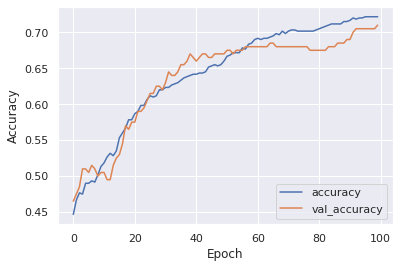

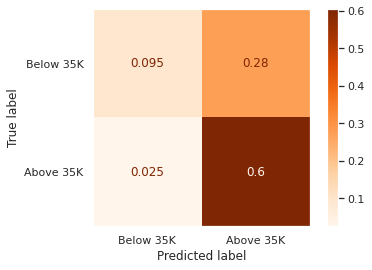

In [17]:
# Compile the model by specifying the optimization algorithm and the loss function.

sgd = SGD(learning_rate=0.01)
ce = BinaryCrossentropy()
acc = BinaryAccuracy()
model.compile(optimizer=sgd, loss=ce, metrics=[acc])
ce_test, acc_test = model.evaluate(X_test, Y_test)
print('The cross entropy loss on the test data:', ce_test)
print('The accuracy on the test data:', acc_test)

m = {}
m[0] = np.sum((Y_train == 0).astype(int)) # Count how many times `0` appears in the target matrix.
m[1] = np.sum((Y_train == 1).astype(int)) # Count how many times `1` appears in the target matrix.
m_total = m[0] + m[1]
class_weight = {0: m_total / (2.0 * m[0]), 1: m_total / (2.0 * m[1])}
# Train the model.
history = model.fit(X_train, Y_train, batch_size=100, epochs=100, validation_data=(X_valid, Y_valid), verbose=1)

# Plot validation MSE, alwys nice to have plots to help us visualise things!
plt.plot(history.history['binary_accuracy'], label='accuracy')
plt.plot(history.history['val_binary_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


Y_test_logit = model.predict(X_test)
Y_test_pred = (Y_test_logit > 0.5).astype(int)

disp = ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_test_pred, normalize='all'),display_labels=['Below 35K', 'Above 35K'])
disp.plot(cmap=plt.cm.Oranges)
plt.grid(False)


acc_test = accuracy_score(Y_test, Y_test_pred)
f1_test = f1_score(Y_test, Y_test_pred, pos_label=1)
print('The accuracy on the test data with the selected hyperparameter:', acc_test)
print('The F1 Score the test data:', f1_test)
pre_test = precision_score(Y_test, Y_test_pred, pos_label=1)
reca_test = precision_score(Y_test, Y_test_pred, pos_label=1)



I got a score of 0.59 on accuracy with L2 but with L2 got 0.62

What can you do if your NN overfits validation data?
• Dataset
• Obtain more data
• Augment data
• Decrease Network size
• Use Regularisation:
• L1/L2
• Same principle as in
linear models
• Dropout
• Early Stopping

**NN with 2 layers**

Model: "logistic_regression_balanced"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_7 (Dense)             (None, 50)                450       
                                                                 
 dense_8 (Dense)             (None, 50)                2550      
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3,051
Trainable params: 3,051
Non-trainable params: 0
_________________________________________________________________
7/7 [==============================] - 0s 5ms/step - loss: 1.4024 - binary_accuracy: 0.4650
The cross entropy loss on the test data: 1.4023836851119995
The accuracy on 

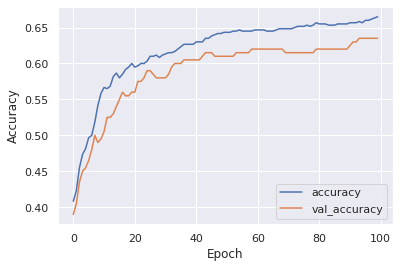

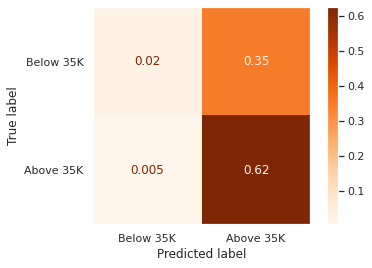

In [13]:
# Define the regularizer.
alpha = 0.01
kernel_regularizer = L2(l2=alpha)

# Define the `Dense` layer.
dense_layer_1 = Dense(units=50, activation=relu, kernel_regularizer=kernel_regularizer)
dense_layer_2 = Dense(units=50, activation=relu, kernel_regularizer=kernel_regularizer)
out_layer = Dense(units=1, activation=sigmoid, kernel_regularizer=kernel_regularizer)

# Define the "virtual" input
input = Input(shape=X_train.shape[1:])

# Define the "virtual" output
output = dense_layer_1(input)
output = dense_layer_2(output)
output = out_layer(output)

# Define the neural network model.
model = Model(inputs=[input], outputs=[output], name='logistic_regression_balanced')

# Output the summary of the model.
model.summary()

sgd = SGD(learning_rate=0.01)
ce = BinaryCrossentropy()
acc = BinaryAccuracy()
model.compile(optimizer=sgd, loss=ce, metrics=[acc])
ce_test, acc_test = model.evaluate(X_test, Y_test)
print('The cross entropy loss on the test data:', ce_test)
print('The accuracy on the test data:', acc_test)

m = {}
m[0] = np.sum((Y_train == 0).astype(int)) # Count how many times `0` appears in the target matrix.
m[1] = np.sum((Y_train == 1).astype(int)) # Count how many times `1` appears in the target matrix.
m_total = m[0] + m[1]
class_weight = {0: m_total / (2.0 * m[0]), 1: m_total / (2.0 * m[1])}

# Train the model.
history = model.fit(X_train, Y_train, batch_size=100, epochs=100, validation_data=(X_valid, Y_valid), verbose=1)

# Plot validation MSE, alwys nice to have plots to help us visualise things!
plt.plot(history.history['binary_accuracy'], label='accuracy')
plt.plot(history.history['val_binary_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


Y_test_logit = model.predict(X_test)
Y_test_pred = (Y_test_logit > 0.5).astype(int)

disp = ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_test_pred, normalize='all'),display_labels=['Below 35K', 'Above 35K'])
disp.plot(cmap=plt.cm.Oranges)
plt.grid(False)

acc_test = accuracy_score(Y_test, Y_test_pred)
f1_test = f1_score(Y_test, Y_test_pred, pos_label=1)
print('The accuracy on the test data with the selected hyperparameter:', acc_test)
print('The F1 score on the test data with the selected hyperparameter:', f1_test)
pre_test = precision_score(Y_test, Y_test_pred, pos_label=1)
print('Precision on validation data:', pre_test)
reca_test = precision_score(Y_test, Y_test_pred, pos_label=1)
print('Recall on validation data:', reca_test)

# **Part 6- Clustering**

In [35]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import silhouette_score

<ipython-input-36-170607b6ae1a>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(list(zip(y, x))).reshape(len(y), 2)


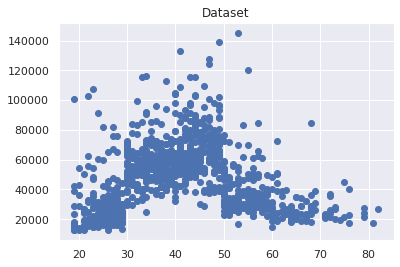

In [36]:
X= IncomeData
X.describe()
#shuffle dataset 
rng = np.random.default_rng(0)
df = IncomeData.iloc[rng.permutation(len(IncomeData))].reset_index(drop=True)
#converting data to array
col =['Age']
#col =['Age', 'SiteSpending', 'SiteTime', 'RecommendImpression','WorkType', 'Education', 'Sex','Region']

x= np.array(df[col])
y= np.array(df['Salary']) #target 
X = np.array(list(zip(y, x))).reshape(len(y), 2)

# Visualizing the data
plt.plot()
plt.title('Dataset')
plt.scatter(x,y)
plt.show()

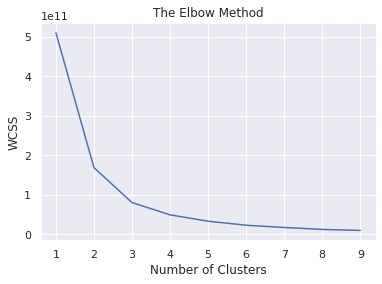

In [37]:

wcss= []

for i in range(1,10):
  kmeans= KMeans(n_clusters=i, init= 'k-means++', max_iter=300, n_init=10, random_state=0)
  kmeans.fit(X)
  wcss.append(kmeans.inertia_)

plt.plot(range(1,10),wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS') #within cluster sum of squares 
plt.title('The Elbow Method')
plt.show()

To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the distortion/inertia start decreasing in a linear fashion. From the above the best K is 4

0.5685588005914269 silhoutte_score
Hopefully, you can get silhouette_score around 0.49


Text(0.5, 1.0, 'KMeans Clusters: Salary Vs Age')

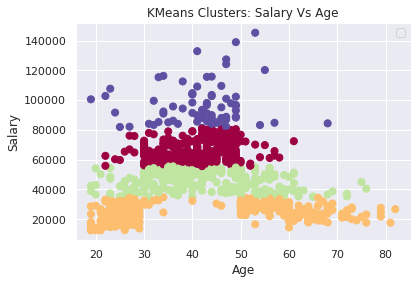

In [38]:
sns.set() # For a more sophisticated plot style.
  # Modify the code: start 
  ##############################

model = KMeans(n_clusters=4, random_state=0)
cluster_labels = model.fit_predict(X)
print(silhouette_score(X, cluster_labels), "silhoutte_score")
  ##############################
  # Modify the code: end
print('Hopefully, you can get silhouette_score around 0.49')
plt.scatter(X[:, 1], X[:, 0], c=cluster_labels, s=50, cmap='Spectral');
plt.legend()
plt.ylabel('Salary')
plt.xlabel('Age')
plt.title('KMeans Clusters: Salary Vs Age')

<ipython-input-17-50688d988e8e>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(list(zip(y, x))).reshape(len(y), 2)


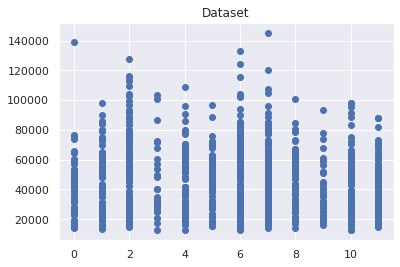

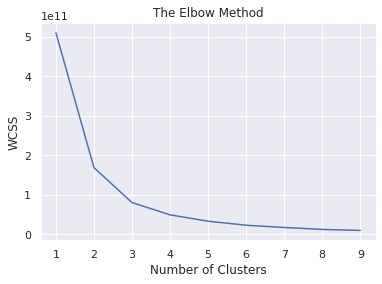

0.5685636776909792
Hopefully, you can get silhouette_score around 0.49


Text(0.5, 1.0, 'KMeans Clusters: Salary Vs Region')

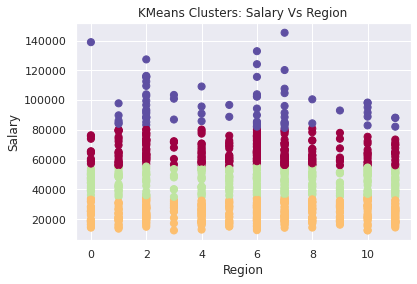

In [17]:
#converting data to array
col =['Region']
#col =['Age', 'SiteSpending', 'SiteTime', 'RecommendImpression','WorkType', 'Education', 'Sex','Region']

x= np.array(df[col])
y= np.array(df['Salary']) #target 
X = np.array(list(zip(y, x))).reshape(len(y), 2)

# Visualizing the data
plt.plot()
plt.title('Dataset')
plt.scatter(x,y)
plt.show()


wcss= []

for i in range(1,10):
  kmeans= KMeans(n_clusters=i, init= 'k-means++', max_iter=300, n_init=10, random_state=0)
  kmeans.fit(X)
  wcss.append(kmeans.inertia_)

plt.plot(range(1,10),wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS') #within cluster sum of squares 
plt.title('The Elbow Method')
plt.show()

sns.set() # For a more sophisticated plot style.
  # Modify the code: start 
  ##############################

model = KMeans(n_clusters=4, random_state=0)
cluster_labels = model.fit_predict(X)
print(silhouette_score(X, cluster_labels))
  ##############################
  # Modify the code: end
print('Hopefully, you can get silhouette_score around 0.49')
plt.scatter(X[:, 1], X[:, 0], c=cluster_labels, s=50, cmap='Spectral');
plt.ylabel('Salary')
plt.xlabel('Region')
plt.title('KMeans Clusters: Salary Vs Region')